# Training Agent, action converters and l2rpn_baselines

It is recommended to have a look at the [0_basic_functionalities](0_basic_functionalities.ipynb), [1_Observation_Agents](1_Observation_Agents.ipynb) and [2_Action_GridManipulation](2_Action_GridManipulation.ipynb) notebooks before getting into this one.

**Objectives**

In this notebook we will expose :
* how to use the "converters": these allow to link several different representations of the actions (for example as `Action` objects or integers).
* how to train a (naive) Agent using reinforcement learning.
* how to inspect (rapidly) the action taken by the Agent.

**NB** In this tutorial, we train an Agent inspired from this blog post: [deep-reinforcement-learning-tutorial-with-open-ai-gym](https://towardsdatascience.com/deep-reinforcement-learning-tutorial-with-open-ai-gym-c0de4471f368). Many other different reinforcement learning tutorials exist. The code presented in this notebook only aims at demonstrating how to use the Grid2Op functionalities to train a Deep Reinforcement learning Agent and inspect its behaviour, but not at building a very smart agent. Nothing about the performance, training strategy, type of Agent, meta parameters, etc, should be retained as a common practice.


In [1]:
import os
import sys
import grid2op

In [2]:
res = None
try:
    from jyquickhelper import add_notebook_menu
    res = add_notebook_menu()
except ModuleNotFoundError:
    print("Impossible to automatically add a menu / table of content to this notebook.\nYou can download \"jyquickhelper\" package with: \n\"pip install jyquickhelper\"")
res

Impossible to automatically add a menu / table of content to this notebook.
You can download "jyquickhelper" package with: 
"pip install jyquickhelper"


## I) Manipulating action representation

The Grid2op package has been built with an "object-oriented" perspective: almost everything is encapsulated in a dedicated `class`. This allows for more customization of the plateform.

The downside of this approach is that machine learning methods, especially in deep learning, often prefer to deal with vectors rather than with "complex" objects. Indeed, as we covered in the previous tutorials on the platform, we saw that building our own actions can be tedious and can sometime require important knowledge of the powergrid.

On the contrary, in most of the standard Reinforcement Learning environments, actions have a higher representation. For example in pacman, there are 4 different types of actions: turn left, turn right, go up and do down. This allows for easy sampling (if you need to achieve an uniform sampling, you simply need to randomly pick a number between 0 and 3 included) and an easy representation: each action can be represented as a different component of a vector of dimension 4 [because there are 4 actions]. 

On the other hand, this representation is not "human friendly". It is quite convenient in the case of pacman because the action space is rather small, making it possible to remember which action corresponds to which component, but in the case of the grid2op package, there are hundreds or even thousands of actions, making it impossible to remember which component corresponds to which action. We suppose that we do not really care about this here, as tutorials on Reinforcement Learning with discrete action space often assume that actions are labeled with integers (such as in pacman for example).

However, to allow RL agent to train more easily, we allow to make some "[Converters](https://grid2op.readthedocs.io/en/latest/converters.html)" whose roles are to allow an agent to deal with a custom representation of the action space. The class [AgentWithConverter](https://grid2op.readthedocs.io/en/latest/agent.html#grid2op.Agent.AgentWithConverter) is perfect for such usage.

In [3]:
# import the usefull class
import numpy as np

from grid2op import make
from grid2op.Agent import RandomAgent 
max_iter = 100 # to make computation much faster we will only consider 50 time steps instead of 287
train_iter = 1000
env_name = "rte_case14_redisp"
env = make(env_name, test=True)
env.seed(0)  # this is to ensure the same action are taken by the "RandomAgent".
my_agent =  RandomAgent(env.action_space)

/home/tezirg/Code/Grid2Op.BDonnot/getting_started/grid2op/MakeEnv/Make.py:223: UserWarning: You are using a development environment. This environment is not intended for training agents.
  warnings.warn(_MAKE_DEV_ENV_WARN)


And that's it. This agent will be able to perform any action, but instead of going through the description of the actions from a powersystem point of view (ie setting what is connected to what, what is disconnected etc.) it will simply choose an integer with the method `my_act`. This integer will then be converted back to a proper action.

Here is an example of the action representation as seen by the Agent (here, integers):

In [4]:
for el in range(3):
    print(my_agent.my_act(None, None))

172
47
117


Below you can see that the `act` function behaves as expected, handling proper `Action` objects:

In [5]:
for el in range(3):
    print(my_agent.act(None, None))

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following element:
	 	 - assign bus 2 to line (origin) 12 [on substation 5]
	 	 - assign bus 2 to line (origin) 13 [on substation 5]
	 	 - assign bus 1 to line (origin) 14 [on substation 5]
	 	 - assign bus 2 to line (extremity) 17 [on substation 5]
	 	 - assign bus 1 to generator 2 [on substation 5]
	 	 - assign bus 1 to load 5 [on substation 5]
This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT force any line status
	 - NOT switch any line status
	 - Change the bus of the following element:
	 	 - switch bus of line (origin) 3 [on substation 8]
	 	 - switch bus of line (extremity) 16 [on substation 8]
	 	 - switch bus of line (extremity) 19 [on substation 8]
	 - NOT force any particular bus configuration
Th

**NB** lots of these actions are equivalent to the "do nothing" action at some point. For example, trying to reconnect a powerline that is already connected will not do anything. The same for topology. If everything is already connected to bus 1, then the action to connect things to bus 1 on the same substation will not affect the powergrid.

## II) Training an Agent

For this tutorial, we will expose to built a Q-learning Agent. Most of the code originated from this blog post (today deleted) [https://towardsdatascience.com/deep-reinforcement-learning-tutorial-with-open-ai-gym-c0de4471f368](https://towardsdatascience.com/deep-reinforcement-learning-tutorial-with-open-ai-gym-c0de4471f368). 

The goal of this notebook is to emphasize the possibility to train agent using grid2op framework. The key message is: as grid2op fully implement the gym API it is rather easy to do. We will use the [l2rpn baselines](https://github.com/rte-france/l2rpn-baselines) repository and implement a Double Duelling Deep Q learning Algorithm. For more information, you can consult the code in the dedicated repository [here](https://github.com/rte-france/l2rpn-baselines/tree/master/l2rpn_baselines/DoubleDuelingDQN).

**Requirements** This notebook require to have `keras` installed on your machine as well as the `l2rpn_baselines` repository

As always in these notebook, we will use the `rte_case14_realistic` test Environment. More data are available if you don't pass the `test=True` parameters.

In this tutorial, we will show how to build a Q-learning Agent. Most of the code (except for the neural network architecture) is inspired from this blog post: [https://towardsdatascience.com/deep-reinforcement-learning-tutorial-with-open-ai-gym-c0de4471f368](https://towardsdatascience.com/deep-reinforcement-learning-tutorial-with-open-ai-gym-c0de4471f368).

**Requirements** This notebook require to have `keras` installed on your machine.

As always in these notebooks, we will use the `case14_fromfile` Environment. Note that no proper care has been taken to set the thermal limits on this grid. Thus, it is unlikely that the agent can learn anything in this context.

### II.A) Defining some "helpers"

The type of Agent we are using requires a bit of set up, independantly of Grid2Op. We will reuse the code shown in 
[https://towardsdatascience.com/deep-reinforcement-learning-tutorial-with-open-ai-gym-c0de4471f368](https://towardsdatascience.com/deep-reinforcement-learning-tutorial-with-open-ai-gym-c0de4471f368) and in [Reinforcement-Learning-Tutorial](https://github.com/abhinavsagar/Reinforcement-Learning-Tutorial) from Abhinav Sagar code under a *MIT license* found here: [MIT License](https://github.com/abhinavsagar/Reinforcement-Learning-Tutorial/blob/master/LICENSE).

This first section aims at defining these classes.

But first let's import the necessary dependencies :

In [6]:
#tf2.0 friendly
import numpy as np
import random
import warnings
import l2rpn_baselines

In [6]:
# Enable GPU memory growth for Windows
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

#tf2.0 friendly
import numpy as np
import random
import warnings
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, subtract, add
from tensorflow.keras.layers import Input, Lambda, Concatenate

#### b) Meta parameters of the methods

In [ ]:
DECAY_RATE = 0.9
BUFFER_SIZE = 40000
MINIBATCH_SIZE = 64
TOT_FRAME = 3000000
EPSILON_DECAY = 10000
MIN_OBSERVATION = 42 #5000
FINAL_EPSILON = 1/300  # have on average 1 random action per scenario of approx 287 time steps
INITIAL_EPSILON = 0.1
TAU = 0.01
ALPHA = 1
# Number of frames to "throw" into network
NUM_FRAMES = 1 ## this has been changed compared to the original implementation.

### II.B) Adapatation of the inputs

For most of the Deep Reinforcement Learning (for example on model used to play an Atari games) the inputs are images and output are integers that encodes for different action types (typically "move up" or "move down" in Atari). For our system (the powergrid) it is rather different. We did our best effort to simply the task of transforming to / from complex structures. Indeed the use of converters such as ([IdToAct](https://grid2op.readthedocs.io/en/latest/converter.html#grid2op.Converter.IdToAct)) allows easily to:
- convert the class "Observation" automatically into vectors
- map the action from integer to complete action type define in the previous notebook.

In essence, a converter substitue to the "action space" of the Agent and is such that:
- Agent manipulates simple structure
- Converter ensure the mapping from this structure to  complex grid2op class Action / Observation
- So that outside of the Agent, it is "as if" the Agent manipulated the original Action / Observation.


#### A note on the converter
To use this converter, Agent must inherit the class [`grid2op.Agent.AgentWithConverter`](https://grid2op.readthedocs.io/en/latest/agent.html#grid2op.Agent.AgentWithConverter) and implement the following interface (showed here as an example):


```python
from grid2op.Agent import AgentWithConverter
class MyAgent(AgentWithConverter):
    def __init__(self, action_space, action_space_converter=None):
        super(MyAgent, self).__init__(action_space=action_space, action_space_converter=action_space_converter)
        # for example you can define here all the actions you will consider
        self.my_actions = [action_space(),
                           action_space({"redispatching": [0,+1]}),
                           action_space({"set_line_status": [(0,-1)]}),
                           action_space({"change_bus": {"lines_or_id": [12]}}),
                          ...
                          ]
        # or load them from a file for example...
        # self.my_action = np.load("my_action_pre_selected.npy")
        
        # you can also in this agent load a neural network...
        self.my_nn_model = model.load("my_saved_neural_network_weights.h5")
    
    def convert_obs(self, observation):
        """
        This method is used to convert the observation, represented as a class Observation in input
        into a "transformed_observation" that will be manipulated by the agent
        An example here will transform the observation into a numpy array.
        
        It is recommended to modify it to suit your needs.
        
        """
        return observation.to_vect()
    
    def convert_act(self, encoded_act):
        """
        This method will take an "encoded_act" (for example a integer) into a valid grid2op action.
        """
        if encoded_act < 0 or encoded_act > len(self.my_action):
            raise RuntimeError("Invalid action with id {}".format(encoded_act))
        return self.my_actions[encoded_act]
    
    def my_act(self, transformed_observation, reward, done=False):
        """
        This is the main function where you can take your decision.
        
        Instead of:
        - calling "act(observation, reward, done)" you implement 
          "my_act(transformed_observation, reward, done)"
        - this manipulates only "transformed_observation" fully flexible as you defined "convert_obs"
        - and returns "encoded_action" that are then digest automatically by 
          "convert_act(encoded_act)" and to return valid actions.
        
        Here we suppose, as many dqn agent, that `my_nn_model` return a vector of size 
        nb_actions filled with number between 0 and 1 and we take the action given the highest score
        """
        pred_score = self.my_nn_model.predict(transformed_observation, reward, done)
        res = np.argmax(pred_score)
        return res
```
And that's it. Nothing else to do, your agent is ready to learn to control powergrid using this only 3 functions.


**NB** A few things are worth noting:
- if you use an agent with converter, do not modify the method **act** but rather change the method **my_act** this is really important !
- some automatic functions can compute the set of all possible actions, so no need to do "self.my_actions = ..." This was done as an example
- if the converter is properly set up, you don't even need to modify "convert_obs(self, observation)" and "convert_act(self, encoded_act)" as this is already performed by the default implementation.

Here, we consider the observation as a whole and do not try any modifications of the features. This means that the vector (the observation) that the agent will receive is going to be really big, not scaled and filled with a lot of information that may not be really useful. It could be tried to select only a subset of the available features and apply a pre-processing function to them.

### II.C) Making the code of the Agent and train it

#### a) Code of the agent

Here we show the most interesting part (for this tutorial) part of the code that are implemented into the baseline. For a full description of the code, you can check [here](https://github.com/rte-france/l2rpn-baselines/tree/master/l2rpn_baselines/DoubleDuelingDQN)

This is the `DoubleDuelingDQN_NN.py` file:

```python
import tensorflow.keras as tfk
class DoubleDuelingDQN_NN(object):
    """Constructs the desired deep q learning network"""
    def __init__(self,
                 action_size,
                 observation_size,                 
                 HIDDEN_FOR_SIMPLICITY
                ):
        self.action_size = action_size
        self.observation_size = observation_size
        HIDDEN_FOR_SIMPLICITY

    def construct_q_network(self):
        """
        we showed this here to tell you it was exactly like any keras implementation
        """
        input_layer = tfk.Input(shape = (self.observation_size * self.num_frames,), name="input_obs")
        lay1 = tfkl.Dense(self.observation_size * 2, name="fc_1")(input_layer)
        lay1 = tfka.relu(lay1, alpha=0.01) #leaky_relu
        ...
        HIDDEN_FOR_SIMPLICITY
        ...
        self.model = tfk.Model(...)

    def random_move(self):
        """
        Moves are encoded by a random number between 0 and the total number of actions.
        Easy to do a random move isn't it ? :-)
        """
        opt_policy = np.random.randint(0, self.action_size)
        return opt_policy
        
    def predict_move(self, data):
        """
        in this example we decided to show 
        """
        model_input = data.reshape(1, self.observation_size * self.num_frames)
        q_actions = self.model.predict(model_input, batch_size = 1)     
        opt_policy = np.argmax(q_actions)
        return opt_policy, q_actions[0]
```

This is the `DoubleDuelingDQN.py` file:
```python
from grid2op.Agent import AgentWithConverter  # all converter agent should inherit this
from grid2op.Converter import IdToAct  # this is the automatic converter to convert action given as ID (integer)
# to valid grid2op action (in particular it is able to compute all actions).

from l2rpn_baselines.DoubleDuelingDQN.DoubleDuelingDQN_NN import DoubleDuelingDQN_NN
class DoubleDuelingDQN(AgentWithConverter):
    def __init__(self,
                 observation_space,
                 action_space,
                 HIDDEN_FOR_SIMPLICITY
                ):
        ...
        HIDDEN_FOR_SIMPLICITY
        ...
        # Load network graph
        self.Qmain = DoubleDuelingDQN_NN(self.action_size,
                                         self.observation_size,
                                         HIDDEN_FOR_SIMPLICITY)
    ## Agent Interface
    def convert_obs(self, observation):
        # Made a custom version to normalize per attribute
        # return observation.to_vect() - like object scaled accordingly
        li_vect=  []
        for el in observation.attr_list_vect:
            v = observation._get_array_from_attr_name(el).astype(np.float)
            v_fix = np.nan_to_num(v)
            v_norm = np.linalg.norm(v_fix)
            if v_norm > 1e8:
                v_res = (v_fix / v_norm) * 10.0
            else:
                v_res = v_fix
            li_vect.append(v_res)
        return np.concatenate(li_vect)

    def convert_act(self, action):
        """
        calling the convert_act method of the base class.
        This is not mandatory as this is the standard behaviour in OOP (object oriented programming)
        """
        return super().convert_act(action)
   
    def my_act(self, state, reward, done=False):
        """
        The complete implementation of the my_act function
        """
        # Register current state to stacking buffer
        self._save_current_frame(state)
        # We need at least num frames to predict
        if len(self.frames) < self.num_frames:
            return 0 # Do nothing
        # Infer with the last num_frames states
        a, _ = self.Qmain.predict_move(np.array(self.frames))  # self.Qmain is of type 'DoubleDuelingDQN_NN' previously defined
        return a
```

#### b) Training the model

Now we can define the model (agent), and then train it.

For that we will use the "train" method provided in the `l2rpn_baselines` repository.

**NB** The code bellow can take a few minutes to run. It's training a Deep Reinforcement Learning Agent afterall. It this takes too long on your machine, you can always decrease the "nb_frame", and set it to 1000 for example. In this case, the Agent will probably not be really good.

**NB** For a real Agent, it would take much longer to train.

In [8]:
# create an environment
env = make(env_name, test=True)  
# don't forget to set "test=False" (or remove it, as False is the default value) for "real" training

# import the train function and train your agent
from l2rpn_baselines.DoubleDuelingDQN import train
agent_name = "test_agent"
save_path = "saved_agent_DDDQN_{}".format(train_iter)
train(env,
      name=agent_name,
      iterations=train_iter,
      save_path=save_path,
      load_path=None, # put something else if you want to reload an agent instead of creating a new one
      logs_path="tf_logs_DDDQN")

/home/benjamin/Documents/grid2op_dev/getting_started/grid2op/MakeEnv/Make.py:224: UserWarning: You are using a development environment. This environment is not intended for training agents.
  warnings.warn(_MAKE_DEV_ENV_WARN)


Step [0] -- Random [0.99]
Survived [2] steps
Total reward [2158.789306640625]
21 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
23 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [3] steps
Total reward [1044.74169921875]
95 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, 

Survived [1] steps
Total reward [1068.7396240234375]
84 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [3] steps
Total reward [2154.937255859375]
77 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
60 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, Fal

77 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
84 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [4] steps
Total reward [2131.5146484375]
59 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_ill

34 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
76 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [8] steps
Total reward [6543.20068359375]
76 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_il

Survived [10] steps
Total reward [8846.018432617188]
70 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
47 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [3] steps
Total reward [1035.7293701171875]
51 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, Fa

73 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [3] steps
Total reward [2155.78173828125]
Survived [7] steps
Total reward [7577.4669189453125]
Survived [2] steps
Total reward [2160.7691650390625]
89 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
65 {'disc_lines': array([False, False, False, False, False, False, False, False, 

Survived [2] steps
Total reward [2134.655029296875]
38 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
59 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
78 {'disc_lines': None, 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('

Survived [3] steps
Total reward [3206.6466064453125]
50 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
79 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [3] steps
Total reward [1053.2554931640625]
60 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, Fa

49 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [2] steps
Total reward [1045.0174560546875]
86 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
95 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_

33 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
26 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [5] steps
Total reward [3194.7520751953125]
Survived [2] steps
Total reward [2159.0745849609375]
54 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, Fa

28 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [3] steps
Total reward [2156.534423828125]
27 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
40 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_i

39 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [6] steps
Total reward [5338.922607421875]
52 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [4] steps
Total reward [3243.8353271484375]
52 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, Fal

Survived [2] steps
Total reward [1065.4189453125]
76 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
67 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
49 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_ill

Survived [4] steps
Total reward [3219.73779296875]
31 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
56 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [5] steps
Total reward [3254.5689697265625]
loss = 0.70086336
Survived [3] steps
Total reward [3187.9376220703125]
Survived [3] steps
Total reward [3252.5880126953125]
Survived [

84 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
98 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Successfully saved model at: saved_agent_DDDQN_1000/test_agent.h5


Logs are saved in the "tf_logs_DDDQN" logs repository. To watch the training (you can even do it while it's training) you can type the command (from a bash command line for example):
```
tensorboard --logdir='tf_logs_DDDQN'
```

In [16]:
nb_frame = 100

env = make("rte_case14_redisp", test=True)  
# don't forget to set "test=False" (or remove it, as False is the default value) for "real" training
my_agent = DeepQAgent(env.action_space, mode="DDQN")
trainer = TrainAgent(agent=my_agent, env=env, reward_fun=RedispReward)
trainer.train(nb_frame)
trainer.agent.deep_q.save_network("saved_agent_"+trainer.agent.mode+".h5")

d:\scripts python\grid2op\grid2op\MakeEnv\Make.py:223: UserWarning: You are using a development environment. This environment is not intended for training agents.
  warnings.warn(_MAKE_DEV_ENV_WARN)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Successfully constructed networks.
Lived with maximum time  11
Earned a total of reward equal to  11135.653564453125
Lived with maximum time  61
Earned a total of reward equal to  68636.55249023438
Successfully saved network.


# To see whether the agent learnt something during training, let's plot the learning curve :

(0, 100)

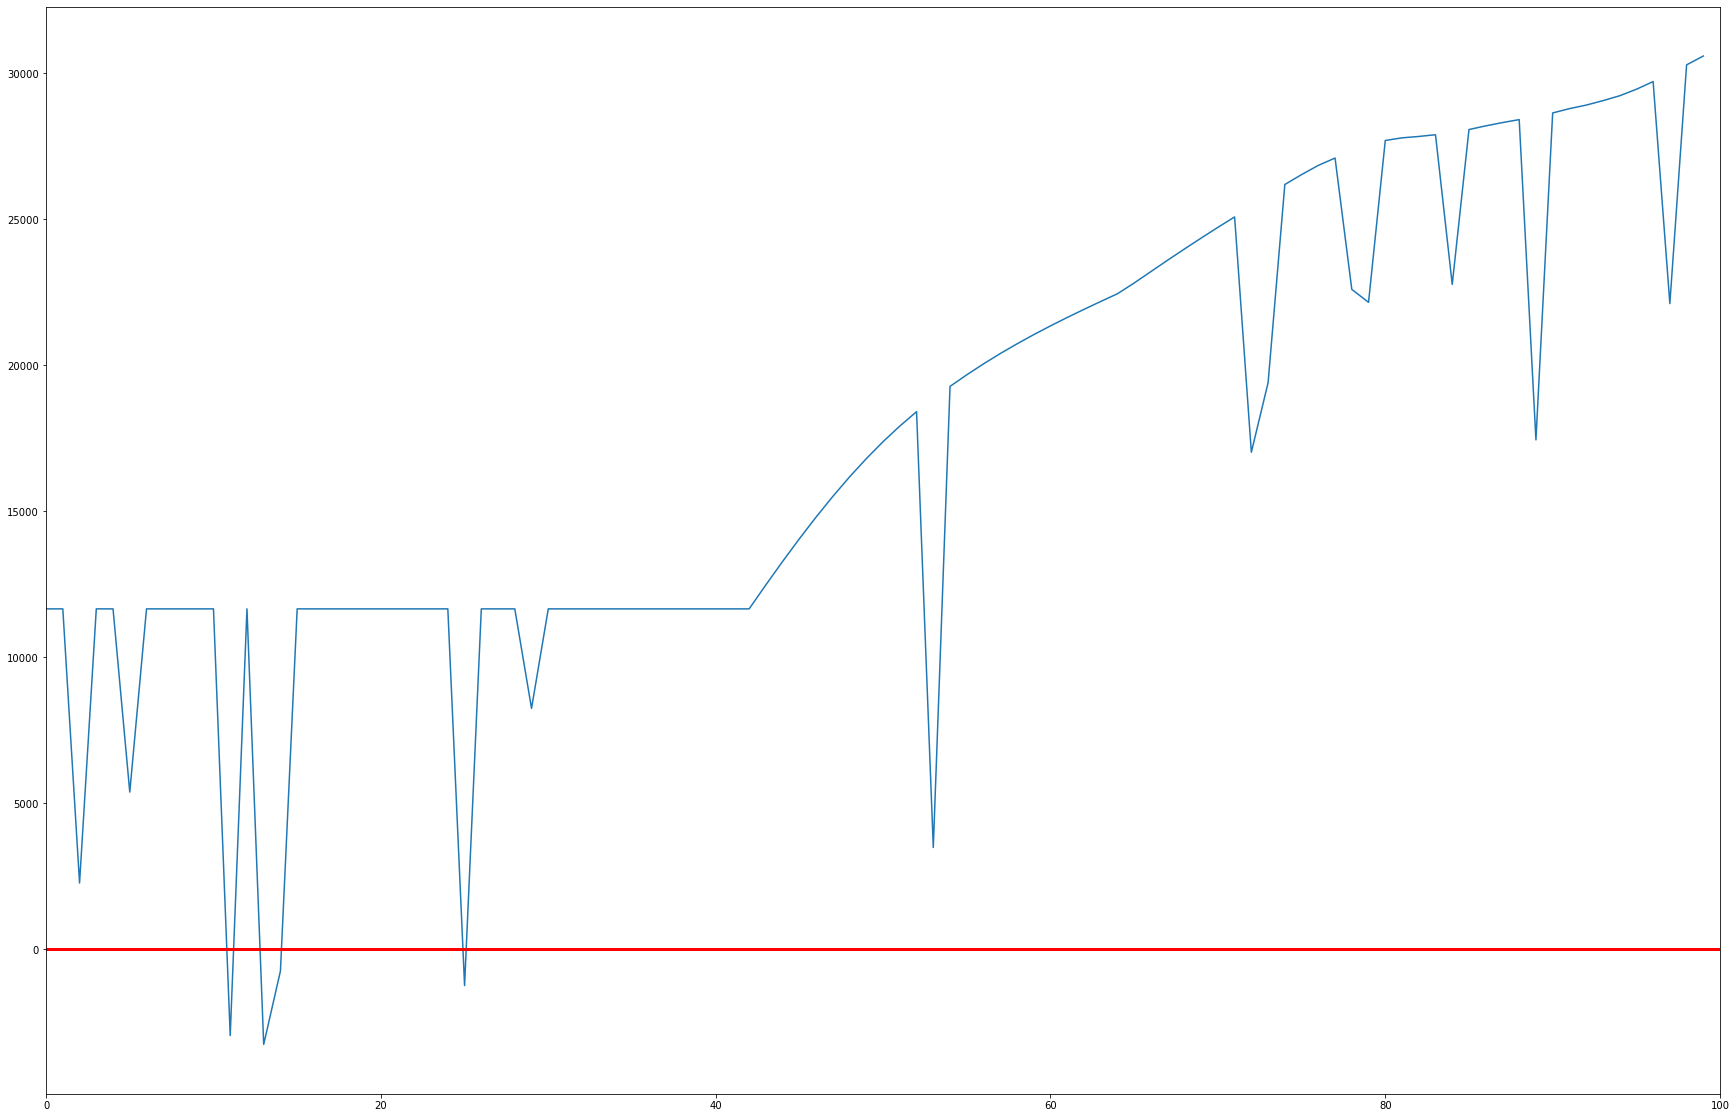

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30,20))
plt.plot(my_agent.deep_q.qvalue_evolution)
plt.axhline(y=0, linewidth=3, color='red')
plt.xlim(0, len(my_agent.deep_q.qvalue_evolution))

The learning curve shown above is really poor, because the agent has not been trained for long enough (and because it uses a very poor input data). If you train this agent for approximately 10-12 hours, using only the relative flows (`obs.rho`, see the last section of this notebook for an example), you will get the following:

![](img/trained_agent.png)

## III) Evaluating the Agent

And now, it is time to test this trained agent.

To do that, we have multiple choices.

We can either re-code the "DeepQAgent" class to load the stored weights (that have been saved during training) when it is initialized (this is not covered in this notebook), or we can also directly specify the "instance" of the Agent to use in the Grid2Op Runner.

Doing this is fairly simple. First, you need to specify that you won't use the "*agentClass*" argument by setting it to ``None``, and secondly you simply have to provide the agent instance to be used as the *agentInstance* argument.

**NB** If you don't do that, the Runner will be created (the constructor will raise an exception). If you choose to feed the "*agentClass*" argument with a class, your agent will be re-instanciated from scratch with this class. If you do re-instanciate your agent and if it is not planned in the class to load pre-trained weights, then **the agent will not be pre-trained** and will be unlikely to perform well on the task.

### III.A) Evaluate the Agent

Now that we have "successfully" trained our Agent, we will evaluate it. As opposed to the training, the evaluation is done classically using a standard Runner.

Note that the Runner will use a "scoring function" that might be different from the "reward function" used during training. In our case, We use the `L2RPNReward` function for both training and evaluating.

In the code below, we commented on what can be different and what must be identical for training and evaluating a model.

In [9]:
from grid2op.Runner import Runner

# chose a scoring function (might be different from the reward you use to train your agent)
from grid2op.Reward import L2RPNReward
scoring_function = L2RPNReward

# load your agent
from l2rpn_baselines.DoubleDuelingDQN import DoubleDuelingDQN
my_agent = DoubleDuelingDQN(env.observation_space, env.action_space)
my_agent.load(os.path.join(save_path, "{}.h5".format(agent_name)))

# here we do that to limit the time take, and will only assess the performance on "max_iter" iteration
dict_params = env.get_params_for_runner()
dict_params["gridStateclass_kwargs"]["max_iter"] =  max_iter
# make a runner from an intialized environment
runner = Runner(**dict_params, agentClass=None, agentInstance=my_agent)

Succesfully loaded network from: saved_agent_DDDQN_1000/test_agent.h5


Now we will run the Agent and save the results. In order to do that, we specify the `path_save` argument. This path allows you to save lots of insights about your Agent's behaviour. Details of all of the information contained in this output are listed in the documentation [here](file:///home/donnotben/Documents/Grid2Op/documentation/html/runner.html).

In [ ]:
import shutil
path_save="trained_agent_log"

# delete the previous stored results
if os.path.exists(path_save):
    shutil.rmtree(path_save)

# run the episode
res = runner.run(nb_episode=2, path_save=path_save)
print("The results for the trained agent are:")
for _, chron_name, cum_reward, nb_time_step, max_ts in res:
    msg_tmp = "\tFor chronics located at {}\n".format(chron_name)
    msg_tmp += "\t\t - total score: {:.6f}\n".format(cum_reward)
    msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
    print(msg_tmp)

The results for the trained agent are:
	For chronics located at 0
		 - total score: 121326.601562
		 - cumulative reward: 8532.783978
		 - number of time steps completed: 100 / 100
	For chronics located at 1
		 - total score: 123084.132812
		 - cumulative reward: 8639.917490
		 - number of time steps completed: 100 / 100


### III.B) Inspect the Agent 

Please refer to the official documentation for more information about the contents of the directory where the data is saved. Note that saving the information is triggered by the "path_save" argument of the "runner.run" function.

The information contained in this output will be saved in a structured way and includes :
For each episode :
  - "episode_meta.json": json file that represents some meta information about:

    - "backend_type": the name of the `grid2op.Backend` class used
    - "chronics_max_timestep": the **maximum** number of timesteps for the chronics used
    - "chronics_path": the path where the temporal data (chronics) are located
    - "env_type": the name of the `grid2op.Environment` class used.
    - "grid_path": the path where the powergrid has been loaded from

  - "episode_times.json": json file that gives some information about the total time spent in multiple parts of the runner, mainly the
    `grid2op.Agent` (and especially its method `grid2op.Agent.act`) and the
    `grid2op.Environment`

  - "_parameters.json": json representation of the `grid2op.Parameters` used for this episode
  - "rewards.npy": numpy 1d-array giving the rewards at each time step. We adopted the convention that the stored
    reward at index `i` is the one observed by the agent at time `i` and **NOT** the reward sent by the
    `grid2op.Environment` after the action has been taken.
  - "exec_times.npy": numpy 1d-array giving the execution time for each time step in the episode
  - "actions.npy": numpy 2d-array giving the actions that have been taken by the `grid2op.Agent`. At row `i` of "actions.npy" is a
    vectorized representation of the action performed by the agent at timestep `i` *ie.* **after** having observed
    the observation present at row `i` of "observation.npy" and the reward showed in row `i` of "rewards.npy".
  - "disc_lines.npy": numpy 2d-array that tells which lines have been disconnected during the simulation of the cascading failure at each
    time step. The same convention has been adopted for "rewards.npy". This means that the powerlines are
    disconnected when the `grid2op.Agent` takes the `grid2op.Action` at time step `i`.
  - "observations.npy": numpy 2d-array representing the `grid2op.Observation` at the disposal of the
    `grid2op.Agent` when he took his action.

We can first look at the repository were the data is stored:

In [ ]:
import os
os.listdir(path_save)

['dict_observation_space.json',
 'dict_action_space.json',
 'dict_env_modification_space.json',
 '0',
 '1']

As we can see, there is only one folder there. It's named "1" because, in the original data, this came from the folder named "1" (the original data is located at "grid2op/data/test_multi_chronics/").

If there were multiple episodes, each episode would have its own folder, with a name similar to the corresponding original name in the data. This is done to make studying of the results easier.

Now let's see what is inside this folder:

In [ ]:
os.listdir(os.path.join(path_save, "0"))

['_parameters.json',
 'env_modifications.npy',
 'other_rewards.json',
 'agent_exec_times.npy',
 'disc_lines_cascading_failure.npy',
 'episode_meta.json',
 'actions.npy',
 'observations.npy',
 'rewards.npy',
 'episode_times.json']

For example, we can load the "actions" chosen by the Agent, and have a look at them.

To do that, we will load the action array and use the `action_space` function to convert it back into the valid action class.

In [ ]:
from grid2op.Episode import EpisodeData
this_episode = EpisodeData.from_disk(path_save, name="0")
all_actions = this_episode.get_actions()
li_actions = []
for i in range(all_actions.shape[0]):
    try:
        tmp = runner.env.action_space.from_vect(all_actions[i,:])
        li_actions.append(tmp)
    except:
        break

In [14]:
!ls $path_save

0  dict_action_space.json	     dict_observation_space.json
1  dict_env_modification_space.json


This allows us to have a deeper look at the action, and their effect. Note that here, we used action that can only **set** the line status, so looking at their effect is pretty straightforward.

Also, note that as oppose to "change", if a powerline is already connected, trying to **set** it as connected has absolutely no impact.

Now we will inspect the actions that has been taken by the agent :

In [ ]:
line_disc = 0
line_reco = 0
for act in li_actions:
    dict_ = act.as_dict()
    if "set_line_status" in dict_:
        line_reco +=  dict_["set_line_status"]["nb_connected"]
        line_disc +=  dict_["set_line_status"]["nb_disconnected"]
print(f'Total reconnected lines : {line_reco}')
print(f'Total disconnected lines : {line_disc}')

Total reconnected lines : 100
Total disconnected lines : 0


As we can see, during this episode, our agent never tries to disconnect a line and tried to reconnect some lines but all the lines were already connected at all times, which means that it did nothing.

We can also analyse the observations of the recorded episode :

In [ ]:
all_observations = this_episode.get_observations()
all_observations = np.load(os.path.join("trained_agent_log", "0", "observations.npy"))
li_observations = []
nb_real_disc = 0
for i in range(all_observations.shape[0]):
    tmp = runner.env.observation_space.from_vect(all_observations[i,:])
    li_observations.append(tmp)
    nb_real_disc += np.sum(tmp.line_status == False)
print(f'Total number of disconnected powerlines cumulated over all the timesteps : {nb_real_disc}')

Total number of disconnected powerlines cumulated over all the timesteps : 0


3

We can also look at the kind of actions that the agent chose:

In [ ]:
actions_count = {}
for act in li_actions:
    act_as_vect = tuple(act.to_vect())
    if not act_as_vect in actions_count:
        actions_count[act_as_vect] = 0
    actions_count[act_as_vect] += 1
print("The agent did {} different valid actions:".format(len(actions_count)))
all_act = np.array(list(actions_count.keys()))
for act in all_act:
    print(runner.env.action_space.from_vect(act))

The agent did 2 different valid actions:
This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration
This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT force any line status
	 - NOT switch any line status
	 - Change the bus of the following element:
	 	 - switch bus of line (origin) 14 [on substation 5]
	 	 - switch bus of line (extremity) 17 [on substation 5]
	 	 - switch bus of generator 2 [on substation 5]
	 - NOT force any particular bus configuration


The action chosen by the agent was :

In [26]:
print(runner.env.action_space.from_vect(np.array(list(actions_count.keys())[0])))

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - force reconnection of 1 powerlines ([16])
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following element:
	 	 - assign bus 1 to line (origin) 16 [on substation 3]
	 	 - assign bus 1 to line (extremity) 16 [on substation 8]


## IV) Improve your Agent 

As we saw, the agent we developped was not really interesting. To improve it, we could think about:

- a better encoding of the observation. For now everything, the whole observation is fed to the neural network, and we do not try to modify it at all. This is a real problem for learning algorithms.
- a better neural network architecture (as said, we didn't pay any attention to it in our model)
- train it for a longer time
- adapt the learning rate and all the hyper-parameters of the learning algorithm.
- etc.

In this notebook, we will focus on changing the observation representation, by only feeding to the agent a part of the available information.

To do so, the only modification that we need to do is to modify the way the observation is converted in the *`convert_obs`* method, and that is it. Nothing else needs to be changed. Here for example, we could think of only using the flow ratio (i.e., the current flow divided by the thermal limit, named rho) instead of feeding the whole observation to the agent

In [18]:
class DoubleDuelingDQN_Improved(DoubleDuelingDQN):
    def convert_obs(self, observation):
        """
        And by just changing that, i can change what is fed to the neural network :-)
        
        NB: i need however to tell in the initialization of the neural network the changes I made...
        """
        return observation.rho
    
    def __init__(self,
                 observation_space,
                 action_space,
                 name=__name__,
                 num_frames=4,
                 is_training=False,
                 batch_size=32,
                 lr=1e-5):
        """
        We have changed the size of the observation, so we need to re create another neural network with
        the proper input size. 
        That is why we need to change this.
        """
        # Call parent constructor
        DoubleDuelingDQN.__init__(self,
                                  observation_space=observation_space,
                                  action_space=action_space,
                                  name=name,
                                  num_frames=num_frames,
                                  is_training=is_training,
                                  batch_size=batch_size,
                                  lr=lr)
        
        # import some constant and the class for this baseline
        from l2rpn_baselines.DoubleDuelingDQN.DoubleDuelingDQN_NN import DoubleDuelingDQN_NN
        from l2rpn_baselines.DoubleDuelingDQN.DoubleDuelingDQN import LR_DECAY_STEPS, LR_DECAY_RATE
        
        # Compute dimensions from intial spaces
        self.observation_size = self.obs_space.n_line

        # Load network graph
        self.Qmain = DoubleDuelingDQN_NN(self.action_size,
                                         self.observation_size,
                                         num_frames = self.num_frames,
                                         learning_rate = self.lr,
                                         learning_rate_decay_steps = LR_DECAY_STEPS,
                                         learning_rate_decay_rate = LR_DECAY_RATE)
        
        # Setup training vars if needed
        if self.is_training:
            self._init_training()

And we can reuse the generic method provided by l2rpn_baselines to train it.

In [19]:
from l2rpn_baselines.utils import train_generic
agent_name = "test_agent2"
save_path = "saved_agent_DDDQN2_{}".format(train_iter)

my_new_agent = DoubleDuelingDQN_Improved(env.observation_space,
                                         env.action_space,
                                         is_training=True,
                                         name=agent_name)

my_new_agent_trained = train_generic(agent=my_new_agent,
                                     env=env,
                                     iterations=train_iter,
                                     save_path="saved_agent_DDDQN_{}".format(train_iter))

Step [0] -- Random [0.99]
Survived [2] steps
Total reward [2162.5540771484375]
37 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
98 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [8] steps
Total reward [6458.381103515625]
Survived [6] steps
Total reward [6417.2862548828125]
73 {'disc_lines': array([False, False, False, False, F

92 {'disc_lines': array([False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
69 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
61 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatchin

71 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
61 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
83 {'disc_lines': None, 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal'), Grid2OpException DivergingPowe

Survived [8] steps
Total reward [8781.166259765625]
loss = 5.2681923
Survived [2] steps
Total reward [2132.68017578125]
Survived [0] steps
Total reward [-10.0]
90 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [3] steps
Total reward [2120.6444091796875]
77 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [3] steps
Total 

34 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [2] steps
Total reward [1065.765625]
35 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [5] steps
Total reward [4285.5828857421875]
Survived [0] steps
Total reward [-10.0]
50 {'disc_lines': None, 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False,

43 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
61 {'disc_lines': None, 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal'), Grid2OpException DivergingPowerFlow DivergingPowerFlow('Powerflow has diverged during computation.')], 'rewards': {}}
Survived [4] steps
Total reward [3241.18359375]
96 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illeg

79 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
71 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [5] steps
Total reward [3237.1083984375]
Survived [1] steps
Total reward [1068.6573486328125]
54 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False

106 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [3] steps
Total reward [2124.6387939453125]
89 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
93 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is

Survived [2] steps
Total reward [2129.04248046875]
83 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [2] steps
Total reward [1067.8953857421875]
41 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
93 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, Fals

Survived [1] steps
Total reward [1068.799072265625]
Survived [3] steps
Total reward [3254.0015869140625]
87 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
76 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [3] steps
Total reward [1034.644287109375]
41 {'disc_lines': array([False, False, False, False, False, False, False, False, 

23 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [7] steps
Total reward [6568.54443359375]
51 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
Survived [4] steps
Total reward [3193.249267578125]
Survived [0] steps
Total reward [-10.0]
72 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       

Survived [5] steps
Total reward [5380.1668701171875]
43 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
93 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_illegal': True, 'is_ambiguous': False, 'is_dispatching_illegal': False, 'is_illegal_reco': False, 'exception': [Grid2OpException IllegalAction IllegalAction('BaseAction illegal')], 'rewards': {}}
54 {'disc_lines': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]), 'is_

Survived [2] steps
Total reward [2163.053955078125]
Survived [0] steps
Total reward [-10.0]
Successfully saved model at: saved_agent_DDDQN_1000/test_agent2.h5


And we re use the code we made above to assess its performance.

In [20]:
runner2 = Runner(**dict_params, agentClass=None, agentInstance=my_new_agent_trained)

# run the episode
res = runner2.run(nb_episode=2, path_save=path_save)
print("The results for the trained agent are:")
for _, chron_name, cum_reward, nb_time_step, max_ts in res:
    msg_tmp = "\tFor chronics located at {}\n".format(chron_name)
    msg_tmp += "\t\t - total score: {:.6f}\n".format(cum_reward)
    msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
    print(msg_tmp)

The results for the trained agent are:
	For chronics located at 0
		 - total score: 3209.357910
		 - number of time steps completed: 4 / 100
	For chronics located at 1
		 - total score: 3253.798584
		 - number of time steps completed: 4 / 100


Of course we would also need to train that agent for a longer time in order to really see if the training was successful.